# PS1 - Neoclassical Growth With Serial Correlation

# Exercise 3.2

I will modify my code from exercise 3 to make the shocks into an autoregressive process. The shock in the next period given the shock in this period can be defined by:
$$
ln(z_t) = \rho ln(z_{t+1}) + v_t 
$$
Where $\sigma_\nu = N(0, \sigma_\nu)$ and $ \rho, \sigma_\nu $ are defined as parameters. 

In [1]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
import random as rand
import ar1_approx as ar1

## Step 1: Set Parameter Values

Parameters:
$$ 
\beta = \text{ Discount Factor} \\
\phi = \text{ Coefficient of relative risk aversion} \\
\delta = \text{ Rate of Capital depreciation} \\
\alpha = \text{ Curvature of production function} \\
\sigma_z = \text{ Standard Deviation of Productivity Shocks} \\
\mu, \rho, \sigma_\nu = \text{ (Related to distribution of shock in autoregressive process)}$$

I also solved analytically for the steady state of capital, since this will help us set up the grid space usefully. (credit to Alex Weinberg for this idea!). 
$$
k_{ss} =  
$$

In [2]:
beta = .96
phi = .5
delta = .05
alpha = .4
sigmaz = .2
mu = 0
rho = .8
sigmanu = .1

I will also define the utility function and production function in this space. As in the problem, I will use a simple production function 
$y_t = z_tk_t^\alpha$ and CRRA utility. $u(c) = \frac{c^{1-\phi)}{1-\phi}$

For cleanness, I also define some more functions. One is for consumption at a given capital today, capital tomorrow, and shock, and one gives the current shock given the last shock and the value of $\nu$.

In [3]:
def util(c):
    '''
    This function defines the utility at a given consumption
    level c. Output should be interpreted as u(c)
    '''
    if phi == 1:
        # Change to log-utility at limit
        output = ln(c)
    else:
        output = (c ** (1 - phi)) / (1 - phi)
    return output

def prod(k, z):
    '''
    This function defines the production function at a given
    pair of capital and shock values. Output should be
    interpreted as y_t.
    '''
    output = z * (k ** alpha)
    return output

def cons(k, kprime, z):
    '''
    This function defines the consumption value implied by a 
    given capital today, shock, and choice of capital tomorrow. 
    '''
    c = prod(k, z) - (kprime - (1 - delta) * k)
    return c

def shock(zprev, nu):
    '''
    This function defines the shock implied by a given previous
    shock and value for nu.
    '''
    lnz = rho * np.log(zprev) + nu 
    z = np.exp(lnz)
    return z

In [4]:
print(prod(1, 1), cons(1, 1, 1))

1.0 0.95


## Step 2: Create Grid Space

In [5]:
'''
------------------------------------------------------------------------
Create Grid for State Space    
------------------------------------------------------------------------
lb_k      = scalar, lower bound of capital grid
ub_k      = scalar, upper bound of capital grid 
size_k    = integer, number of grid points in capital state space
size_z    = integer, number of grid points in shock state space
k_grid    = vector, size_w x 1 vector of capital grid points 
------------------------------------------------------------------------
'''
lb_k = 10
ub_k = 15
size_k = 25
size_z = 25
k_grid = np.linspace(lb_k, ub_k, size_k)


'''
Create grid of shocks
'''

ln_z_grid, pi_t = ar1.addacooper(size_z, mu, rho, sigmanu)
z_grid = np.exp(ln_z_grid)
pi = np.transpose(pi_t)

'''
------------------------------------------------------------------------
Create grid of current utility values    
------------------------------------------------------------------------
C        = matrix (Cube), current consumption (c = cons(k, kprime, z)))
U        = matrix (Cube), current utility = u(C)
EU       = matrix, current period expected utility value for all
           choices of k, and k', (rows are k, columns k')
------------------------------------------------------------------------
'''

C = np.zeros((size_k, size_k, size_z))
for i in range(size_k): # loop over k
    for j in range((size_k)): # loop over k' 
        for l in range((size_z)): # loop over z
            C[i, j, l] = cons(k_grid[i], k_grid[j], z_grid[l])
''' Now, it is possible that consumption may pop out as negative for 
certain choices of k, k', and l. So I'll replace this possiblity with a
tiny value of consumption to impose non-negativity. '''
C[C<=0] = 1e-15

# Now compute the utilities of all these possible consumptions.
U = util(C)
U[C == 1e-15] = -1e12 # Impose very negative utility for zero consumption

'''
This time, I do not deviate from Jason's method by adding in the 
randomness. I will implement that later, within the iteration step.
'''

"\nThis time, I do not deviate from Jason's method by adding in the \nrandomness. I will implement that later, within the iteration step.\n"

## Step 3: Value Function Iteration


In [6]:
'''
------------------------------------------------------------------------
Value Function Iteration    
------------------------------------------------------------------------
VFtol     = scalar, tolerance required for value function to converge
VFdist    = scalar, distance between last two value functions
VFmaxiter = integer, maximum number of iterations for value function
V         = matrix, the value function at each iteration 
            (function of z, k_t)
Vmat      = matrix, the value for each possible combination of k and k'
Vstore    = matrix, stores V at each iteration 
VFiter    = integer, current iteration number
TV        = vector, the value function after applying the Bellman operator
PF        = vector, indicies of choices of k' for all k
VF        = vector, the "true" value function
------------------------------------------------------------------------
'''
VFtol = 1e-6
VFdist = 7.0
VFmaxiter = 3000
V = np.zeros((size_k, size_z)) #inital guess at value function
Vmat = np.zeros((size_k, size_k, size_z)) #initialize Vmat matrix
Vstore = np.zeros((size_k, size_z, VFmaxiter))
VFiter = 1
while VFdist > VFtol and VFiter < VFmaxiter:
    for i in range(size_k): # Loop over k
        for j in range(size_k): # Loop over k'
            for q in range(size_k): # loop over z
                #define the expected value of the utility for this z
                EV = 0
                for qq in range (size_k):
                    EV += pi[q, qq] * V[j, qq]
                Vmat[i, j, q] = U[i, j, q] + beta * EV
    #store for graphing
    Vstore[:, :, VFiter] = V.reshape(size_k, size_z,)
    TV = Vmat.max(1) #Apply max operator to Vmat to get V(k)
    PF = np.argmax(Vmat, axis=1) #Create policy function
    VFdist = (np.absolute(V - TV)).max() #Check distance
    print("Iteration ", VFiter, "dist =", VFdist)
    V = TV
    VFiter += 1
    
if VFiter < VFmaxiter:
    print('Value function converged after this many iterations:', VFiter)
else:
    print('Value function did not converge')  
    
VF = V # Solution to the functional equation

Iteration  1 dist = 5.824197554646102
Iteration  2 dist = 3.5765383242058517
Iteration  3 dist = 3.1972122848846
Iteration  4 dist = 2.9466600041822204
Iteration  5 dist = 2.7483061070063783
Iteration  6 dist = 2.5812445451760944
Iteration  7 dist = 2.4346585372731404
Iteration  8 dist = 2.302923364995795
Iteration  9 dist = 2.1841898603960708
Iteration  10 dist = 2.076300764347863
Iteration  11 dist = 1.9773715691812335
Iteration  12 dist = 1.8858947517233702
Iteration  13 dist = 1.8008411689801989
Iteration  14 dist = 1.721304298734438
Iteration  15 dist = 1.6465863029643302
Iteration  16 dist = 1.5761413663958663
Iteration  17 dist = 1.5095086918891596
Iteration  18 dist = 1.4463106994057426
Iteration  19 dist = 1.3862401968176172
Iteration  20 dist = 1.3290419747120765
Iteration  21 dist = 1.2744982088152454
Iteration  22 dist = 1.2224231405857608
Iteration  23 dist = 1.1726566193820531
Iteration  24 dist = 1.125058511146598
Iteration  25 dist = 1.0795046546171179
Iteration  26 dis

Iteration  199 dist = 0.0008856607162925911
Iteration  200 dist = 0.0008502342876397506
Iteration  201 dist = 0.0008162249161500768
Iteration  202 dist = 0.0007835759195131686
Iteration  203 dist = 0.0007522328827178626
Iteration  204 dist = 0.0007221435674154009
Iteration  205 dist = 0.0006932578247358379
Iteration  206 dist = 0.0006655275117424253
Iteration  207 dist = 0.0006389064112681808
Iteration  208 dist = 0.0006133501548077902
Iteration  209 dist = 0.0005888161486211629
Iteration  210 dist = 0.0005652635026933694
Iteration  211 dist = 0.0005426529625935927
Iteration  212 dist = 0.0005209468441051968
Iteration  213 dist = 0.0005001089703142725
Iteration  214 dist = 0.0004801046115119334
Iteration  215 dist = 0.000460900427043498
Iteration  216 dist = 0.0004424644099856323
Iteration  217 dist = 0.0004247658335714277
Iteration  218 dist = 0.0004077752002302759
Iteration  219 dist = 0.00039146419223357043
Iteration  220 dist = 0.00037580562457151245
Iteration  221 dist = 0.0003607

### Visualize output

<Figure size 432x288 with 0 Axes>

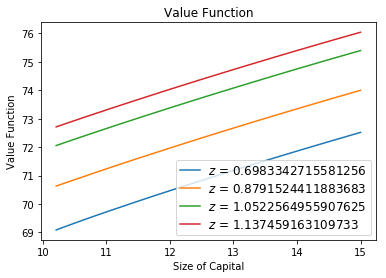

In [7]:
# Plot value function
plt.figure()
fig, ax = plt.subplots()
ax.plot(k_grid[1:], VF[1:, 0], label='$z$ = ' + str(z_grid[0]))
ax.plot(k_grid[1:], VF[1:, 5], label='$z$ = ' + str(z_grid[5]))
ax.plot(k_grid[1:], VF[1:, 15], label='$z$ = ' + str(z_grid[15]))
ax.plot(k_grid[1:], VF[1:, 19], label='$z$ = ' + str(z_grid[19]))
# Now add the legend with some customizations.
legend = ax.legend(loc='lower right', shadow=False)
# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize('large')
for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
plt.xlabel('Size of Capital')
plt.ylabel('Value Function')
plt.title('Value Function')
plt.show()

<Figure size 432x288 with 0 Axes>

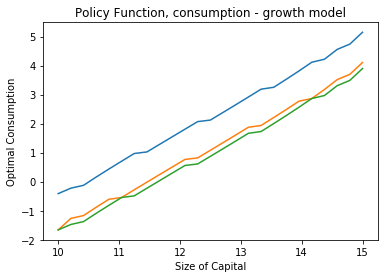

In [8]:
#Plot optimal consumption rule as a function of capital
optK = k_grid[PF]
optC = z_grid * k_grid ** (alpha) + (1 - delta) * k_grid - optK
plt.figure()
fig, ax = plt.subplots()
ax.plot(k_grid[:], optC[:][12], label='Consumption')
ax.plot(k_grid[:], optC[:][18], label='Consumption')
ax.plot(k_grid[:], optC[:][19], label='Consumption')
# Now add the legend with some customizations.
#legend = ax.legend(loc='upper left', shadow=False)
# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize('large')
for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
plt.xlabel('Size of Capital')
plt.ylabel('Optimal Consumption')
plt.title('Policy Function, consumption - growth model')
plt.show()


<Figure size 432x288 with 0 Axes>

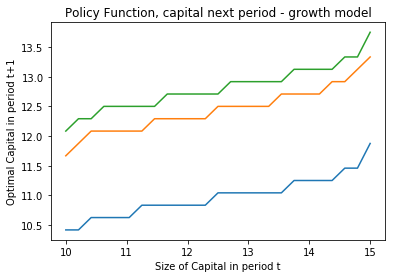

In [9]:
#Plot optimal capital in period t + 1 rule as a function of cake size
optK = k_grid[PF]
plt.figure()
fig, ax = plt.subplots()
ax.plot(k_grid[:], optK[:][4], label='Capital in period t+1')
ax.plot(k_grid[:], optK[:][12], label='Capital in period t+1')
ax.plot(k_grid[:], optK[:][14], label='Capital in period t+1')
# Now add the legend with some customizations.
#legend = ax.legend(loc='upper left', shadow=False)
# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize('large')
for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
plt.xlabel('Size of Capital in period t')
plt.ylabel('Optimal Capital in period t+1')
plt.title('Policy Function, capital next period - growth model')
plt.show()
